# Tutorial 6: Neural networks

Welcome to the sixth tutorial of the course 'Machine learning for Precision Medicine'.

In this tutorial we will implement a neural network architecture, which involves the following steps.

1) initialize the weights  
2) Forward Proagation  
    2.1) Perform linear transformation of input  
    2.2) Compute Activations from the linear transformations   
3) calculate the loss  
4) Backpropagation  
5) update weights 

We will use an artificial dataset here, which we want to separate into two classes. Let's generate the and look at the data first...

In [2]:
# Import necessary python modules
import numpy as np
from sklearn.datasets import make_circles
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# we generate a toy-dataset that is not linearly separable:
X, y = make_circles(n_samples=1000, factor=.4, noise=.10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=50, cmap=plt.cm.Spectral, edgecolors='black');


From this plot we can see that the data is not linearly separable. So let's use a neural network model to classify the blue from the red data points. Here we will use a neural network, with 4 hidden layers with 25, 50, 50 and 25 units respectively and an output layer of 2 units for our binary classification (red or blue).

In [3]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

As discussed in the lecture, each neuron in our neural network will perform a linear transformation of it's input values, which will produce an intermediate value $z$. We apply a non-linear activation function to $z$ in order to get the *activation* $a$, which in turn will be fed to other neurons, until we arrive at the final neuron(s) which constitute the model output. By sequentially performing many of these operations (linear transformation + non-linear activation), we are able to compute very complex non-linear functions of the input variables.

For each neuron, the linear transformation is parameterized by a weight column-vector $\mathbf{w}$ and a bias parameter $b$. Our non-linear activation functions in this exercise will not have any adjustable parameters.

We call a group of neurons which are parameterized in the same way (i.e. their weight vectors have the same length), and perform the same kind of operation on the same input as a *layer*. We can stack the transposed weight vectors of all neurons ${n}$ in the same layer ${l}$ on top of each other to form a weight matrix $\mathbf{W}^{\{l\}}$ and bias vector $\mathbf{b}^{\{l\}}$. Following this definition, the weight matrix of the layer ${l}$, $\mathbf{W}^{\{l\}}$, is an $n^{\{l\}}$ (number of neurons in this layer) by $n^{\{l-1\}}$ (number of neurons in the previous layer) matrix, and $\mathbf{b}^{\{l\}}$ is a vector of vector of length $n^{\{l\}}$.

In this exercise, we will look at a certain class of neural networks called a feed-forward or densely connected neural network. In a densely connected neural network, each neuron of a layer is connected to all neurons of the previous layer, i.e. every neuron in layer ${l}$, will recieve all the output $\mathbf{a}^{\{l-1\}}$, where $\mathbf{a}^{\{l-1\}}$ is the vector that results from concatenating the $n^{\{l-1\}}$ activations of the previous layer $\{a_1,a_2,...,a_{n^{\{l-1\}}}\}$. The first layer ${(l = 1)}$, receives the input ${\mathbf{a}^{\{0\}}} = \mathbf{x}$, where $\mathbf{x}$ is a single observation in our training set $\mathbf{X}$.

We can express the operations happening within a single layer using matrix multiplaction:
$$  \mathbf{z}^{\{l\}} = \mathbf{W}^{\{l\}} \mathbf{a}^{\{l-1\}} + \mathbf{b}^{\{l\}}$$
$$  \mathbf{a}^{\{l\}} = \phi^{\{l\}}(\mathbf{z}^{\{l\}})$$

where $\phi^{\{l\}}$ is the activation function for layer $l$.

Finally, we are not feeding single observation $\mathbf{x}$ to our network, but rather we are processing an entire batch of observations $\mathbf{X}_t$, where $\mathbf{X}_t$ is an $m$ by $i$ matrix, corresponding to $m$ observations $\mathbf{x}^T$ stacked on top of each other, each having $i$ features. 

$$  \mathbf{Z}^{\{l\}} = \mathbf{W}^{\{l\}} \mathbf{A}^{\{l-1\}} + \mathbf{b}^{\{l\}} $$
$$  \mathbf{A}^{\{l\}} = \phi^{\{l\}}(\mathbf{Z})  $$

Where $\mathbf{A}^{\{0\}} = \mathbf{X}_t$ and $\mathbf{b}^{\{l\}}$ is added to the matrix $\mathbf{W}^{\{l\}} \mathbf{A}^{\{l-1\}}$ via [broadcasting](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html), i.e. it is added element-wise to each column. $\mathbf{A}^{\{l\}}$ and $\mathbf{Z}^{\{l\}}$ both have the shape $(n^{\{l\}}, m)$





To start with the implementation, we have to initialize weights across the entire network architechture. How to initialize weights before training is also a big research topic in Deep Learning. Here, we will just use randomly generated numbers. 

### Forward propagation

In [4]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        # save everything in a dictionary
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

Now we want to implement the activation functions for our linear transformations. We can activate neurons either with the sigmoid or relu function. 

In the lecture we were introduced to the ReLU activation function, which will use to activate the neurons in the hidden layers:

$$ ReLU(\mathbf{Z}) = max(0,\mathbf{Z}) $$

Our final output layer will use the sigmoid activation function, which was already introduced in the last exercise:

$$ \sigma(\mathbf{Z}) = \frac{1}{1+exp(-\mathbf{Z})} $$

## Task 1:
Implement the sigmoid and relu functions, which take the linear transformation Z as input.

In [5]:
# STUDENT
def sigmoid(Z):
    sig = 1 / (1 + np.exp(-Z))#your code
    return sig

def relu(Z):
    relu = Z * (Z > 0)# faster than np.maximum(0,Z)#your_code
    return relu

Now, we will implement the forward propagtion of a single layer. This function requires the activations of the previous layer stored in A_prev, the weights stored in W_curr and the bias stored in b_curr, as well as an argument which activation function you want to use. 

## Task 2: 
Implement the linear transformation input $\mathbf{Z}$ of the next layer with this function.

In [6]:
#STUDENT

def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    
    Z_curr = np.dot(W_curr,A_prev)+b_curr#your_code
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

We will now implement the forward propagation through the entire network and call the function above for each layer. 
The function here requires our input data $\mathbf{X}$, our initialized weights and biases stored in params_values and the network architecture. The function will output the activation of the last layer, as well as the memory of all activations, weights and biases from the hidden layers below. 

## Task 3:
Call the forward propagation of a single layer.

In [7]:
# STUDENT

def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activation=activ_function_curr)#your_code
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory



We need to compare our output from the output layer $\hat{\mathbf{Y}}$ with the true $\mathbf{Y}$ and calculate the loss, or cost. This is our objective function that we seek to minimize. 

\begin{equation}
J(w,b) =  -\frac{1}{m} \sum_{i=1}^{m}{y log\hat{y}^{(i)} + (1-y^{(i)}) log(1-\hat{y}^{(i)})}
\end{equation}

## Task 4:
Implement the cost, based on the formula above.

In [8]:
# STUDENT

def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -np.sum(Y*np.log(Y_hat)+(1-Y)*np.log(1-Y_hat))/m # your code
    return np.squeeze(cost)

Our output layer outputs $\hat{Y}$ with values between 0 and 1 because it applies the sigmoid function. These values correspond to the probability of belonging to class 1. We now have to set a threshold, which defines, that we assign class 1 to a sample that has a value higher than 0.5 and class 0 if smaller or equals 0.5. Afterwards we calculate the accuracy of our predicted labels, by checking how many $\hat{\mathbf{Y}}$ were equals to the true $\mathbf{Y}$

In [9]:
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

### Backward propagation

We have now implemented the full forward propagation through the network. We now wish to implement back propagation in a similar way. This will require us to calculate the partial derivatives of our Loss function with respect to the trainable model parameters.

For a single layer of our neural network, the gradients are calculated according to the following formulae:

$$ \mathbf{dW}^{\{l\}} = \frac{\delta L}{\delta\mathbf{W}^{\{l\}}} = \frac{1}{m} \mathbf{dZ}^{\{l\}} \mathbf{A}^{\{l-1\}T} $$

$$ \mathbf{db}^{\{l\}} = \frac{\delta L}{\delta\mathbf{b}^{\{l\}}} = \frac{1}{m} \sum_{i=1}^{m} \mathbf{dZ}^{\{l\}(i)} $$

$$ \mathbf{dA}^{\{l-1\}} = \frac{\delta L}{\delta\mathbf{A}^{\{l-1\}}} = \mathbf{W}^{\{l\}T} \mathbf{dZ}^{\{l\}} $$

$$ \mathbf{dZ}^{\{l\}} = \mathbf{dA}^{\{l\}} * \phi^{\{l\}'}(\mathbf{Z}^{\{l\}}) $$

We already saw that these formulae make use of the cached values for $\{\mathbf{Z}^{\{1\}}, \mathbf{Z}^{\{2\}}, ..., \mathbf{Z}^{\{n\}}\}$ and $\{\mathbf{A}^{\{1\}}, \mathbf{A}^{\{2\}}, ..., \mathbf{A}^{\{n\}}\}$ calculated during forward propagation. In a first step, let's implement the formula for $\mathbf{dZ}$ for the sigmoid and ReLU activation functions.

## Task 5:

Implement `relu_backward(dA, Z)` and `sigmoid_backward(dA, Z)`. Both functions take a matrix `dA` ($\mathbf{dA}$), *which will be passed during back-propagation* and cached values `Z` ($\mathbf{Z}$), and return $\mathbf{dA} * \phi^{'}(\mathbf{Z})$, where we substitute $\phi^{'}$ with $ReLU^{'}(z)$ or $\sigma^{'}(z)$, performed element-wise for all values in $\mathbf{Z}$, respectively. **Be aware that $*$ here denotes element-wise multiplication, not matrix-multiplication!**

$$ \mathbf{dZ} = \mathbf{dA} * \phi^{'}(\mathbf{Z}) $$

$$  ReLU^{'}(z) =   \begin{equation}
   \begin{cases}
     1, & \text{if}\ z>0 \\
     0, & \text{otherwise}
   \end{cases}
\end{equation} $$

$$ \sigma^{'}(z) = \sigma (z)\cdot (1-\sigma(z)) $$

In [10]:
# STUDENT

def relu_backward(dA, Z):
    dZ = dA * (Z > 0)

    return dZ;

def sigmoid_backward(dA, Z):
    # tip: make use of the "sigmoid"-function we implemented above 
    sig = (sigmoid(Z)*(1-sigmoid(Z)))#your_code
    dZ = dA*sig#your_code
    return dZ

## Task 6:

We now wish to implement a function `single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu")`, where:

* `dA_curr` corresponds to $\mathbf{dA}^{\{l\}}$, passed during back propagation, needed to calculate $\mathbf{dZ}^{\{l\}}$
* `W_curr` corresponds to $\mathbf{W}^{\{l\}}$, the current weight matrix
* `b_curr` corresponds to $\mathbf{b}^{\{l\}}$, the current bias vector 
* `A_prev` corresponds to $\mathbf{A}^{\{l-l\}}$, cached activation-values of the previous layer, needed to calculate $\mathbf{dW}^{\{l\}}$

`single_layer_backward_propagation` should calculate the gradients of the trainable parameters ($\mathbf{dW}^{\{l\}}, \mathbf{db}^{\{l\}}$) for a single layer $l$. It will also calculate $\mathbf{dZ}^{\{l\}}$ (depending on which activation function was used) in order to calculate $\mathbf{dA}^{\{l-1\}}$, which will be passed on to the preceding layer ${l-1}$ during back propagation. Use the formulae introduced above to perform the necessary calculations.

It returns `dA_prev`, `dW_curr`, `db_curr`, which correspond to $\mathbf{dA}^{\{l-1\}}$, $\mathbf{dW}^{\{l\}}, \mathbf{db}^{\{l\}}$

**IMPORTANT:** when calculating `db_curr`, make use of the function `np.sum(..., axis=..., keepdims=True)`, make sure you set `keepdims=True`, this will ensure that `db_curr` and `b_curr` keep the same dimensions, which is important in oder to perform parameter updates later.

In [11]:
# STUDENT

def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr,np.transpose(A_prev))/m#your_code
    # derivative of the vector b
    db_curr = np.sum(dZ_curr)/m#your_code
    # derivative of the matrix A_prev
    dA_prev = np.dot(np.transpose(W_curr),dZ_curr)#your_code

    return dA_prev, dW_curr, db_curr

In the function `full_forward_propagation` you implemented above, you initialized the activations that feed in to the first layer with ${A^{\{0\}}} = X $, i.e. `A_curr = X`. We will also need values $\mathbf{dA}^{\{n\}}$ for or last layer $n$ in order to initialize back-propagation:

$$ \mathbf{dA}^{\{n\}} = \frac{\delta L}{\delta\mathbf{A}^{\{n\}}} = -(\frac{\mathbf{Y}}{\mathbf{\hat{Y}}} - \frac{1-\mathbf{Y}}{1-\mathbf{\hat{Y}}}) $$

where ${\hat{\mathbf{Y}}} = \mathbf{A}^{\{n\}}$ are our predicted values for the target variable. We have implemented this calculation for you:

In [12]:
def loss_backward(Y, Y_hat):
    return - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat))

## Task 7:

Above we implemented the function `full_forward_propagation`, which sequentially iterates over the layers starting from the input layer in order to perfrom forward propagation. It calculates the transformations defined by the weight and bias parameters and activation functions, and stores the intermediate outputs in memory.

We now write a similar function called `full_back_propagation`, which iterates over the layers in reverse order, starting from the output layer in order to perform back propagation. It makes use of the intermediate outputs in order to calculate the gradients of the loss function with respect to the model parameters. It stores these gradients in a dictionary `grads_values`, which is returned in the end.

Complete the function `full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture)`, where:

* `Y_hat` corresponds to $\hat{\mathbf{Y}} = \mathbf{A}^{\{n\}}$
* `Y` corresponds to $\mathbf{Y}$, the training data labels, which are eihter 0 or 1
* `memory` is the dictionary of cached values for $\{\mathbf{Z}^{\{1\}}, \mathbf{Z}^{\{2\}}, ..., \mathbf{Z}^{\{n\}}\}$ and $\{\mathbf{A}^{\{1\}}, \mathbf{A}^{\{2\}}, ..., \mathbf{A}^{\{n\}}\}$
* `params_values` is the dictionary of current parameter values, i.e. $\{\mathbf{W}^{\{1\}}, \mathbf{W}^{\{2\}}, ..., \mathbf{W}^{\{n\}}\}$ and $\{\mathbf{b}^{\{1\}}, \mathbf{b}^{\{2\}}, ..., \mathbf{b}^{\{n\}}\}$
* `nn_architecture` is the dictionary that defines the model architecture

Here, you only have to call the single_layer_backward_propagation() function with the right parameters.

In [13]:
# STUDENT

def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = loss_backward(Y, Y_hat)
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)#your_code
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

Now that we have a way to get the gradients for all the trainable parameters, it is time to write a function that will allow us to update the parameters using the update rule introduced in the last exercise:

$$ \mathbf{W}^{\{l\}} = \mathbf{W}^{\{l\}} - \alpha \mathbf{dW}^{\{l\}} $$
$$ \mathbf{b}^{\{l\}} = \mathbf{b}^{\{l\}} - \alpha \mathbf{db}^{\{l\}} $$

## Task 8:

Complete the function `update` below. It takes the following parameters:

* `params_values` dictionary of parameter values $\{\mathbf{W}^{\{1\}}, \mathbf{W}^{\{2\}}, ..., \mathbf{W}^{\{n\}}\}$ and $\{\mathbf{b}^{\{1\}}, \mathbf{b}^{\{2\}}, ..., \mathbf{b}^{\{n\}}\}$
* `grads_values` dictionary of gradients for the trainable parameters $\{\mathbf{dW}^{\{1\}}, \mathbf{dW}^{\{2\}}, ..., \mathbf{dW}^{\{n\}}\}$ and $\{\mathbf{db}^{\{1\}}, \mathbf{db}^{\{2\}}, ..., \mathbf{db}^{\{n\}}\}$
* `nn_architecture` dictionary defining the neural network architecture
* `learning_rate`, the learning rate $\alpha$

In [14]:
# STUDENT

def update(params_values, grads_values, nn_architecture, learning_rate):
    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] = params_values["W" + str(layer_idx)]-learning_rate*grads_values["dW" + str(layer_idx)]#your_code        
        params_values["b" + str(layer_idx)] = params_values["b" + str(layer_idx)]-learning_rate*grads_values["db" + str(layer_idx)]#your_code 

    return params_values;

## Task 9:
Now we have everything we need to train our model. The final task of this exercise, is to insert the functions you implemented above in the right places below. If you understood what you are doing, this should be more or less self-explanatory ;)

In [15]:
# STUDENT

def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False):
    # initiation of neural net parameters
    
    params_values = init_layers(nn_architecture, seed = 99)#your_code
    
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cache = full_forward_propagation(X, params_values, nn_architecture)#your_code
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cache, params_values, nn_architecture)
        
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            
    return params_values, cost_history, accuracy_history

In [16]:
# Training
params_values, cost_history, accuracy_history = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01, verbose=True)

Iteration: 00000 - cost: 0.69383 - accuracy: 0.50333
Iteration: 00050 - cost: 0.69358 - accuracy: 0.50333
Iteration: 00100 - cost: 0.69307 - accuracy: 0.50333
Iteration: 00150 - cost: 0.69293 - accuracy: 0.50333
Iteration: 00200 - cost: 0.69275 - accuracy: 0.50333
Iteration: 00250 - cost: 0.69267 - accuracy: 0.50333
Iteration: 00300 - cost: 0.69260 - accuracy: 0.50333
Iteration: 00350 - cost: 0.69255 - accuracy: 0.50333
Iteration: 00400 - cost: 0.69250 - accuracy: 0.50333
Iteration: 00450 - cost: 0.69245 - accuracy: 0.50333
Iteration: 00500 - cost: 0.69241 - accuracy: 0.50333
Iteration: 00550 - cost: 0.69237 - accuracy: 0.50333
Iteration: 00600 - cost: 0.69234 - accuracy: 0.50333
Iteration: 00650 - cost: 0.69230 - accuracy: 0.50333
Iteration: 00700 - cost: 0.69227 - accuracy: 0.50333
Iteration: 00750 - cost: 0.69223 - accuracy: 0.50333
Iteration: 00800 - cost: 0.69220 - accuracy: 0.50333
Iteration: 00850 - cost: 0.69216 - accuracy: 0.50333
Iteration: 00900 - cost: 0.69213 - accuracy: 0

Iteration: 07750 - cost: 0.02569 - accuracy: 1.00000
Iteration: 07800 - cost: 0.02434 - accuracy: 1.00000
Iteration: 07850 - cost: 0.02312 - accuracy: 1.00000
Iteration: 07900 - cost: 0.02201 - accuracy: 1.00000
Iteration: 07950 - cost: 0.02100 - accuracy: 1.00000
Iteration: 08000 - cost: 0.02007 - accuracy: 1.00000
Iteration: 08050 - cost: 0.01923 - accuracy: 1.00000
Iteration: 08100 - cost: 0.01845 - accuracy: 1.00000
Iteration: 08150 - cost: 0.01773 - accuracy: 1.00000
Iteration: 08200 - cost: 0.01706 - accuracy: 1.00000
Iteration: 08250 - cost: 0.01645 - accuracy: 1.00000
Iteration: 08300 - cost: 0.01587 - accuracy: 1.00000
Iteration: 08350 - cost: 0.01533 - accuracy: 1.00000
Iteration: 08400 - cost: 0.01483 - accuracy: 1.00000
Iteration: 08450 - cost: 0.01436 - accuracy: 1.00000
Iteration: 08500 - cost: 0.01392 - accuracy: 1.00000
Iteration: 08550 - cost: 0.01351 - accuracy: 1.00000
Iteration: 08600 - cost: 0.01312 - accuracy: 1.00000
Iteration: 08650 - cost: 0.01275 - accuracy: 1

In [17]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [18]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 1.00


And last but not least, let's plot how the accuracy and cost evolved over the training epochs...

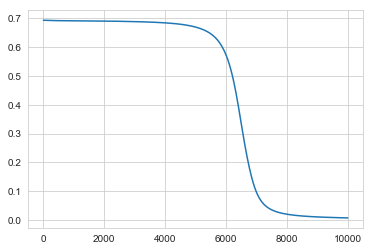

In [20]:
plt.plot(np.arange(10000), np.array(cost_history))

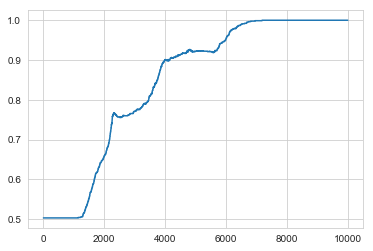

In [21]:
plt.plot(np.arange(10000), np.array(accuracy_history))

### Question 1:
What can you say about the learning progress of the model?

A: The model is continously improving. Obviously, the progress is capped at 100% accuracy.

### Question 2:
Can you find out how many trainable parameters our model contains? Do you think that this number of parameters is appropriate for our classification task?

A: The number of trainable parameters is the number of all weights and biasses for all layers. In this implementation it is the sum of lengths of the flatten entries in the params_values dictionary returned by the init_layers function. This results to 5226 parameters. So this is ca. five times our input data which might enough to give each datapoint a representation in the parameters. It would be problematic if the number of parameters is smaller than the number of datapoints. So this number should be appropriate.

In [22]:
sum_params=0
params_values=init_layers(NN_ARCHITECTURE, seed = 99)
for layer in params_values.keys():
    sum_params+=len(params_values[layer].flatten())
print(sum_params)

5226


Congratulations, you made it through the sixth tutorial of this course!

# Submitting your assignment

Please rename your notebook under your full name and **submit it on the moodle platform**. If you have problems to do so, you can also send it again to machinelearning.dhc@gmail.com

Please rename the file to 1_LinRegTut_<GROUP\>.ipynb and replace <GROUP\> with your group-name.

As this is also the first time for us preparing this tutorial, you are welcome to give us feedback to help us improve this tutorial.  

Thank you!  

Jana & Remo